In [186]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import talib

Load data from files.

In [187]:
ddf = dd.read_parquet("data/intraday/AAPL/*.parquet", index='Datetime', calculate_divisions=True)
print(f"Shape: ({len(ddf)}, {len(ddf.columns)})")
print(ddf.npartitions)
print(ddf.divisions)
print(ddf)

Shape: (2516240, 5)
46
(Timestamp('2007-12-31 12:25:00'), Timestamp('2008-04-29 12:00:00'), Timestamp('2008-09-05 17:01:00'), Timestamp('2009-01-09 14:54:00'), Timestamp('2009-05-28 16:10:00'), Timestamp('2009-10-06 14:26:00'), Timestamp('2010-03-09 19:16:00'), Timestamp('2010-07-01 17:24:00'), Timestamp('2010-11-08 19:09:00'), Timestamp('2011-03-03 19:39:00'), Timestamp('2011-07-22 17:28:00'), Timestamp('2011-11-22 14:48:00'), Timestamp('2012-03-26 16:33:00'), Timestamp('2012-07-23 18:36:00'), Timestamp('2012-11-19 16:33:00'), Timestamp('2013-03-27 12:45:00'), Timestamp('2013-08-06 20:16:00'), Timestamp('2013-12-06 14:08:00'), Timestamp('2014-04-30 17:17:00'), Timestamp('2014-08-25 11:09:00'), Timestamp('2014-12-17 18:18:00'), Timestamp('2015-04-10 12:28:00'), Timestamp('2015-08-03 13:10:00'), Timestamp('2015-11-24 18:36:00'), Timestamp('2016-03-30 17:31:00'), Timestamp('2016-07-29 14:24:00'), Timestamp('2016-12-09 13:39:00'), Timestamp('2017-05-08 13:30:00'), Timestamp('2017-09-18 10

Add potential missing 1m data in between samples.

In [188]:
ddf = ddf.resample('1T').agg(
    {
        'Open':     'first', 
        'High':     'max', 
        'Low':      'min', 
        'Close':    'last', 
        'Volume':   'sum'
    })

# ffill missing data values    
ddf[['Open', 'High', 'Low', 'Close']] = ddf[['Open', 'High', 'Low', 'Close']].ffill()
ddf['Volume'] = ddf['Volume'].fillna(0)

ddf.head(10)

,Open,High,Low,Close,Volume
Datetime,,,,,
2007-12-31 12:25:00,199.86,199.86,199.86,199.86,100.0
2007-12-31 12:26:00,199.86,199.86,199.86,199.86,0.0
2007-12-31 12:27:00,199.86,199.86,199.86,199.86,0.0
2007-12-31 12:28:00,199.86,199.86,199.86,199.86,0.0
2007-12-31 12:29:00,199.86,199.86,199.86,199.86,0.0
2007-12-31 12:30:00,199.86,199.86,199.86,199.86,0.0
2007-12-31 12:31:00,199.86,199.86,199.86,199.86,0.0
2007-12-31 12:32:00,199.86,199.86,199.86,199.86,0.0
2007-12-31 12:33:00,199.86,199.86,199.86,199.86,0.0


In [189]:
ddf.isna().sum().compute()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [190]:
ddf = ddf.resample("120T").agg(
    {
        'Open':     'first', 
        'High':     'max', 
        'Low':      'min', 
        'Close':    'last', 
        'Volume':   'sum'
    })

print(f"Shape: ({len(ddf)}, {len(ddf.columns)})")
print(ddf.npartitions)
print(ddf.divisions)
print(ddf)

Shape: (65743, 5)
46
(Timestamp('2007-12-31 12:00:00'), Timestamp('2008-04-29 12:00:00'), Timestamp('2008-09-05 16:00:00'), Timestamp('2009-01-09 14:00:00'), Timestamp('2009-05-28 16:00:00'), Timestamp('2009-10-06 14:00:00'), Timestamp('2010-03-09 18:00:00'), Timestamp('2010-07-01 16:00:00'), Timestamp('2010-11-08 18:00:00'), Timestamp('2011-03-03 18:00:00'), Timestamp('2011-07-22 16:00:00'), Timestamp('2011-11-22 14:00:00'), Timestamp('2012-03-26 16:00:00'), Timestamp('2012-07-23 18:00:00'), Timestamp('2012-11-19 16:00:00'), Timestamp('2013-03-27 12:00:00'), Timestamp('2013-08-06 20:00:00'), Timestamp('2013-12-06 14:00:00'), Timestamp('2014-04-30 16:00:00'), Timestamp('2014-08-25 10:00:00'), Timestamp('2014-12-17 18:00:00'), Timestamp('2015-04-10 12:00:00'), Timestamp('2015-08-03 12:00:00'), Timestamp('2015-11-24 18:00:00'), Timestamp('2016-03-30 16:00:00'), Timestamp('2016-07-29 14:00:00'), Timestamp('2016-12-09 12:00:00'), Timestamp('2017-05-08 12:00:00'), Timestamp('2017-09-18 10:0

Keep only data, which was collected between the actual trading hours (for US: 09:30am - 16:00pm).

In [191]:
mask = (ddf.index.dayofweek < 5) & (ddf.index.dt.time.astype(str) >= "09:30") & (ddf.index.dt.time.astype(str) <= "16:00")
ddf = ddf.loc[mask]

# update devisions
ddf = ddf.reset_index().set_index('Datetime')

print(f"Shape: ({len(ddf)}, {len(ddf.columns)})")
print(ddf.npartitions)
print(ddf.divisions)
print(ddf.head())
print(ddf.tail())

Shape: (11744, 5)
46
(Timestamp('2007-12-31 12:00:00'), Timestamp('2008-04-29 12:00:00'), Timestamp('2008-09-08 10:00:00'), Timestamp('2009-01-09 14:00:00'), Timestamp('2009-05-29 10:00:00'), Timestamp('2009-10-06 14:00:00'), Timestamp('2010-03-10 10:00:00'), Timestamp('2010-07-02 10:00:00'), Timestamp('2010-11-09 10:00:00'), Timestamp('2011-03-04 10:00:00'), Timestamp('2011-07-25 10:00:00'), Timestamp('2011-11-22 14:00:00'), Timestamp('2012-03-27 10:00:00'), Timestamp('2012-07-24 10:00:00'), Timestamp('2012-11-20 10:00:00'), Timestamp('2013-03-27 12:00:00'), Timestamp('2013-08-07 10:00:00'), Timestamp('2013-12-06 14:00:00'), Timestamp('2014-05-01 10:00:00'), Timestamp('2014-08-25 10:00:00'), Timestamp('2014-12-18 10:00:00'), Timestamp('2015-04-10 12:00:00'), Timestamp('2015-08-03 12:00:00'), Timestamp('2015-11-25 10:00:00'), Timestamp('2016-03-31 10:00:00'), Timestamp('2016-07-29 14:00:00'), Timestamp('2016-12-09 12:00:00'), Timestamp('2017-05-08 12:00:00'), Timestamp('2017-09-18 10:0

In [192]:
ddf.isna().sum().compute()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [193]:
df = ddf.compute()
df['Ticker'] = 'AAPL'
df

,Open,High,Low,Close,Volume,Ticker
Datetime,,,,,,
2007-12-31 12:00:00,199.86,200.75,199.86,200.2000,124470.0,AAPL
2007-12-31 14:00:00,200.20,200.27,197.97,199.3100,5586444.0,AAPL
2008-01-01 10:00:00,198.46,198.50,198.45,198.5000,0.0,AAPL
2008-01-01 12:00:00,198.46,198.50,198.45,198.5000,0.0,AAPL
2008-01-01 14:00:00,198.46,198.50,198.45,198.5000,0.0,AAPL
...,...,...,...,...,...,...
2022-12-29 12:00:00,127.20,128.12,126.13,128.0100,1011798.0,AAPL
2022-12-29 14:00:00,127.98,129.98,127.73,129.9542,27903058.0,AAPL
2022-12-30 10:00:00,129.10,129.19,128.85,129.1500,29139.0,AAPL


In [194]:
def calculate_turbulence(data):
    # can add other market assets
    df = data.copy()
    df_price_pivot = df.pivot(columns="Ticker", values="Close")

    # use returns to calculate turbulence
    df_price_pivot = df_price_pivot.pct_change()

    unique_date = df.index.unique()
    # start after a year
    start = 252
    turbulence_index = [0] * start
    # turbulence_index = [0]
    count = 0

    for i in range(start, len(unique_date)):
        current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]

        # use one year rolling window to calcualte covariance
        hist_price = df_price_pivot[(df_price_pivot.index < unique_date[i]) & (df_price_pivot.index >= unique_date[i - 252])]

        # Drop tickers which has number missing values more than the "oldest" ticker
        filtered_hist_price = hist_price.iloc[hist_price.isna().sum().min() :].dropna(axis=1)

        cov_temp = filtered_hist_price.cov()
        current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(filtered_hist_price, axis=0)
        # cov_temp = hist_price.cov()
        # current_temp=(current_price - np.mean(hist_price,axis=0))

        temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(current_temp.values.T)
        if temp > 0:
            count += 1
            if count > 2:
                turbulence_temp = temp[0][0]
            else:
                # avoid large outlier because of the calculation just begins
                turbulence_temp = 0
        else:
            turbulence_temp = 0
        turbulence_index.append(turbulence_temp)

    try:
        turbulence_index = pd.DataFrame(
            {
                "Datetime": df_price_pivot.index, 
                "turbulence": turbulence_index
            })
    except ValueError:
        raise Exception("Turbulence information could not be added.")
    return turbulence_index


turbulence_index = calculate_turbulence(df)

df = df.merge(turbulence_index, on="Datetime")

<AxesSubplot: >

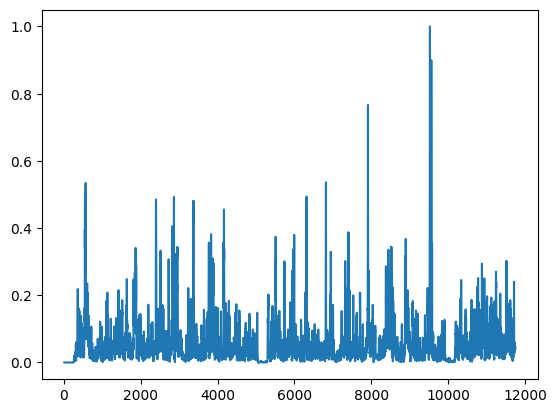

In [195]:
df['turbulence'] = df['turbulence'].rolling(int(1440 / 120)).median()
df['turbulence'] = (df['turbulence'] - df['turbulence'].min()) / (df['turbulence'].max() - df['turbulence'].min())
df['turbulence'].plot()


Enrich dataframe with technical featrues.

In [196]:
df['sma'] = talib.SMA(df['Close'])
df['rsi'] = talib.RSI(df['Close'])
df['macd'], df['macd_s'], df['macd_h'] = talib.MACD(df['Close'])
df['pdi'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'])
df['mdi'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'])
df['dx'] = talib.DX(df['High'], df['Low'], df['Close'])
df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'])
df['adxr'] = talib.ADXR(df['High'], df['Low'], df['Close'])
df['cci'] = talib.CCI(df['High'], df['Low'], df['Close'])
df['boll_u'], df['boll_m'], df['boll_l'] = talib.BBANDS(df['Close'])
df['weekday'] = df.index.dayofweek

AttributeError: 'Int64Index' object has no attribute 'dayofweek'

In [ ]:
df.sample(10)

,Open,High,Low,Close,Volume,sma,rsi,macd,macd_s,macd_h,pdi,mdi,dx,adx,adxr,cci,boll_u,boll_m,boll_l,weekday
Datetime,,,,,,,,,,,,,,,,,,,,
2008-08-04 13:30:00,156.5999,157.9000,155.51,156.2400,6152023.0,159.047163,42.412322,-1.266203,-1.163256,-0.102946,23.835320,24.344197,1.056210,9.342203,12.606324,-93.254039,157.483209,156.45000,155.416791,0
2008-08-05 13:30:00,155.4200,156.9000,154.82,156.8800,6956833.0,158.391830,45.790074,-1.258008,-1.233247,-0.024761,21.435383,24.612432,6.899457,9.294797,11.031357,-58.371357,157.722250,156.25000,154.777750,1
2022-05-26 12:00:00,138.7501,140.9400,137.33,137.3900,2124681.0,141.201333,39.715849,-1.595164,-1.850410,0.255246,16.169135,19.773805,10.028869,28.781027,34.754917,-88.110952,140.657231,138.82700,136.996769,3
2019-04-23 13:30:00,204.4300,205.9900,203.90,205.9700,7295607.0,201.620210,72.447373,1.420151,1.346775,0.073376,28.881866,20.332882,17.370778,21.177820,19.263845,229.703704,205.996814,204.81200,203.627186,1
2021-09-13 10:30:00,150.3200,150.5500,149.92,150.2900,435438.0,154.425933,30.803180,-0.223366,0.490504,-0.713871,13.274588,41.605338,51.623157,18.559042,17.696276,-249.352216,157.475176,152.93100,148.386824,0
2016-10-28 12:00:00,114.1400,114.4400,113.86,113.8600,123768.0,116.419920,32.377107,-0.683350,-0.444975,-0.238375,31.879553,31.752899,0.199040,22.861075,27.394875,-82.657330,115.916457,114.73000,113.543543,4
2009-08-27 15:00:00,165.3500,166.4900,165.12,166.4564,1970490.0,167.211410,45.258042,0.301918,0.822275,-0.520357,18.145641,32.573332,28.446340,23.044973,26.321745,-174.541191,169.553327,167.18528,164.817233,3
2010-09-23 15:00:00,290.3300,292.7600,290.18,291.5745,5279839.0,278.272633,82.980189,5.115496,4.780377,0.335119,48.705251,6.607936,76.107195,52.703420,43.708319,180.359926,292.696700,288.34690,283.997100,3
2014-11-10 15:00:00,109.0200,109.3300,108.91,109.1100,7184691.0,108.541790,59.431734,0.498664,0.601621,-0.102957,15.869437,29.222341,29.612725,24.202024,27.554297,101.220710,109.237329,109.04400,108.850671,0
